In [1]:
# Importing the libraries

import pandas as pd
from scipy import sparse
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 
from imblearn.over_sampling import RandomOverSampler 

In [2]:
# Reading the data and storing them as dataframes
features = pd.read_csv('features_cleaned_multi.csv') 
labels = pd.read_csv('labels_multi.csv') 

In [3]:
# Vectorizing the title and storing it as a sparse matrix

title_vectorizer = CountVectorizer(ngram_range=(2, 2), analyzer='word')
sparse_matrix_for_title = title_vectorizer.fit_transform(features['title'])
sparse.save_npz("sparse_matrix_for_title.npz", sparse_matrix_for_title)
sparse_matrix_for_title_load = sparse.load_npz("sparse_matrix_for_title.npz")   

# Vectorizing the content and storing it as a sparse matrix
content_vectorizer = CountVectorizer(ngram_range=(2, 2), analyzer='word')
sparse_matrix_for_content = content_vectorizer.fit_transform(features['content'])
sparse.save_npz("sparse_matrix_for_content.npz", sparse_matrix_for_content)
sparse_matrix_for_content_load = sparse.load_npz("sparse_matrix_for_content.npz")

In [4]:
import pickle

# Saving the vectorized title and content as pickle files
with open('vectorized_title.pickle', 'wb') as f: 
    pickle.dump(title_vectorizer, f)

with open('vectorized_content.pickle', 'wb') as f:
    pickle.dump(content_vectorizer, f)    

In [5]:
# Combining the sparse matrices of title and content
matrix = hstack([sparse_matrix_for_content_load,sparse_matrix_for_title_load]) 

In [6]:
# Defining the X and y variables for the model
X = matrix 
y = labels 
y = np.ravel(y)

In [7]:
# Splitting the data into train, validation and test sets. The data is split in 80/10/10 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=0)

# Oversampling the data using RandomOverSampler
# This is done to balance the data as the data is highly imbalanced
oversampler = RandomOverSampler(random_state=0)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

# Creating the model and fitting the data, note that an alpha value of 0.1 is used
# As it was found to be the best value for the model
# This result can be seen in Part_3_multi.ipynb as well as in the tuning part of this notebook
model = ComplementNB(alpha=0.1) 
model.fit(X_train_oversampled, y_train_oversampled)

# Printing the accuracy score of the model
print(model.score(X_train_oversampled, y_train_oversampled))

# Creates a prediction array for the validation set
predictions_NB = model.predict(X_val)

# Prints the accuracy score of the model
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, y_val)*100)

y_val_pred = model.predict(X_val) 

# Prints the classification report of the model
report = classification_report(y_val, y_val_pred)
print("classification report:")
print(report)

: 

: 

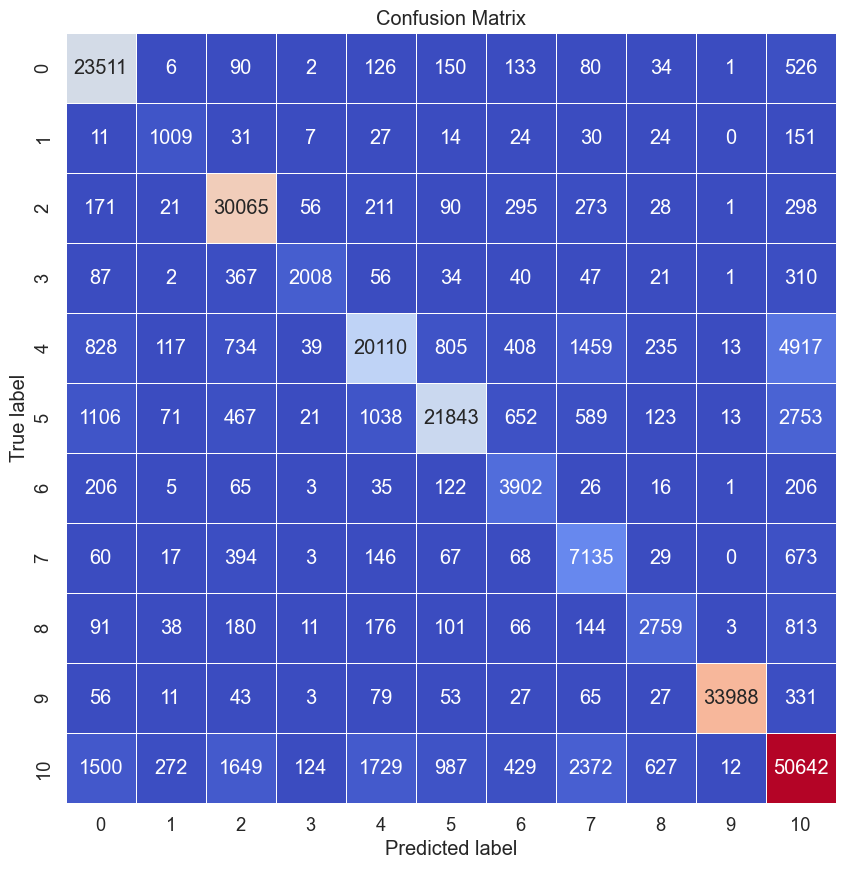

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Set up the plot
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.2)

# Create the heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm', linewidths=0.5, square=True, cbar=False, xticklabels=True, yticklabels=True)

# Customize the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


Tuning

In [ ]:
# Define the parameter grid for the grid search
param_grid = [0.00001,0.0001,0.001, 0.01,0.1,1,10,100,1000,10000]

# Initialize the best_C and best_score variables
best_alpha = None
best_score = 0

for pg in param_grid:
    model = ComplementNB(alpha=pg)
    
    model.fit(X_train_oversampled, y_train_oversampled)
    
    y_val_pred = model.predict(X_val)
    
    # Calculate the accuracy score for the current C value
    score = accuracy_score(y_val, y_val_pred)
    
    # Print the current C value and its accuracy score
    print(f"alpha: {pg}, Accuracy: {score}")
    
    # Update the best_C and best_score variables if the current score is higher than the previous best
    if score > best_score:
        best_alpha = pg
        best_score = score
    
# Print the best C value and its accuracy score
print(f"\nBest alpha: {best_alpha}, Best Accuracy: {best_score}")